# Montevideo

Instance took from the set of bycicle network design problems faced by Inco.

In [1]:
from functools import partial
import os

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import networkx as nx

import bcnetwork as bc

## Utils

In [2]:
raw_data_path = '../instances/montevideo'
data_path = '../data/montevideo_v4'
resources_path = '../thesis/resources'

## General information

In [3]:
demand_df = pd.read_csv(os.path.join(raw_data_path, 'demands.csv'))
d3000_df = pd.read_csv(os.path.join(raw_data_path, 'demands_d3000.0.csv'))

total_montevideo_demand = demand_df.demand.sum()
total_demand_d3000 = d3000_df.demand.sum()

print("Demand under 3000km:", total_demand_d3000 / total_montevideo_demand)
print("Top 600 demand under 3000km:", d3000_df.iloc[:600].demand.sum() / total_demand_d3000)
print("Total demand:", total_montevideo_demand)
print("Total demand under 3000km:", total_demand_d3000)

Demand under 3000km: 0.4038320634230991
Top 600 demand under 3000km: 0.6766337179341706
Total demand: 6568837
Total demand under 3000km: 2652707


## Draw solutions

Draw solutions computed by the CPLEX solver elsewhere.


In [4]:
def read_instances(data_path):
    instances = []

    for entry in os.scandir(data_path):
        if 'solution' in entry.path or not entry.path.endswith('pkl'):
            continue

        dirname, basename = os.path.dirname(entry.path), os.path.basename(entry.path)
        solution_path = os.path.join(dirname,'solution_' + basename)
        if not os.path.exists(solution_path):
            continue

        model = bc.model.Model.load(entry.path)
        solution = bc.solution.Solution.load(solution_path)

        instances.append((model, solution))
    
    return instances

In [5]:
draw_config = dict(
    figsize=(8, 7),
)

split_draw_config = dict()

In [6]:
instances = read_instances(data_path)
first_round_instances = [i for i in instances if '0.1' not in i[0].name]

instances_number = {
    'montevideo_d3000.0_linear_0.4_budget_factor': 1,
    'montevideo_d3000.0_inv_logit_0.4_budget_factor': 2,
    'montevideo_d3000.0_linear_0.8_budget_factor': 3,
    'montevideo_d3000.0_inv_logit_0.8_budget_factor': 4,
    'montevideo_d3000.0_linear_1.6_budget_factor': 5,
    'montevideo_d3000.0_inv_logit_1.6_budget_factor': 6,
}

Sample Model out of 7 models
Nodes: 136
Edges: 636
Multigraph: False
Directed: True
OD count: 600
Breakpoint count: 10
Budget: 1296880.949638854


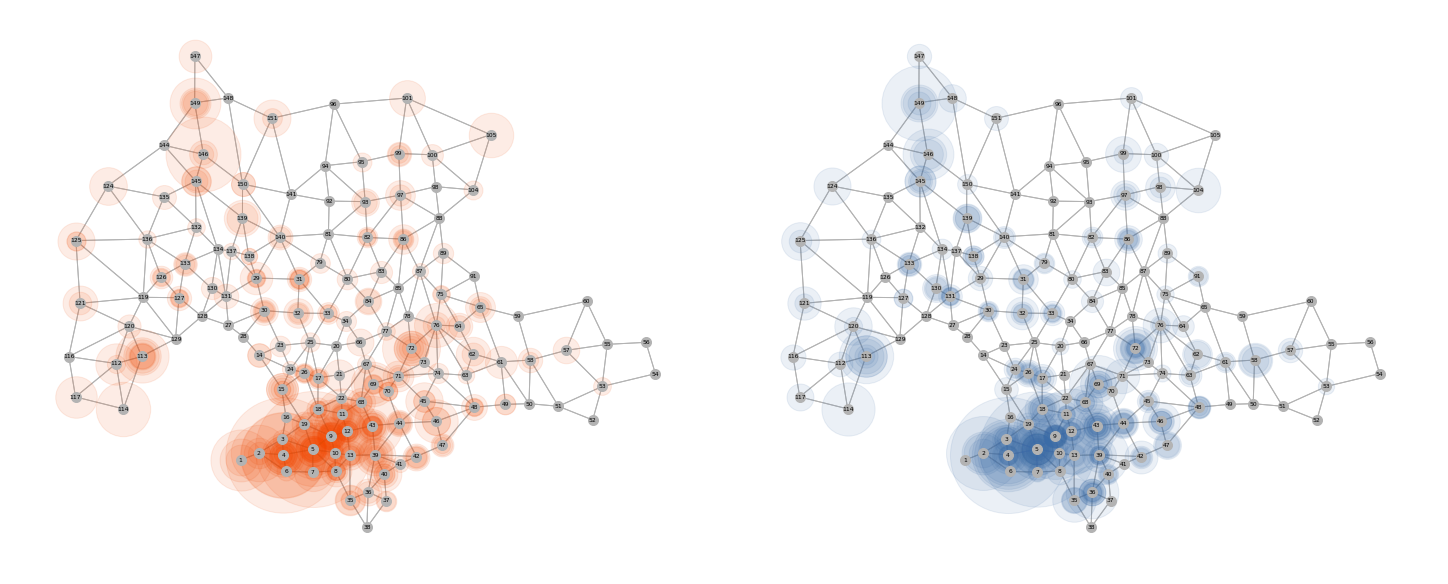

In [7]:
sample_model = instances[0][0]
sample_graph = sample_model.graph

print(f'Sample Model out of', len(instances), 'models')
print(f'Nodes: {sample_graph.number_of_nodes()}')
print(f'Edges: {sample_graph.number_of_edges()}')
print(f'Multigraph: {sample_graph.is_multigraph()}')
print(f'Directed: {sample_graph.is_directed()}')
print(f'OD count: {len(sample_model.odpairs)}')
print(f'Breakpoint count: {len(sample_model.breakpoints)}')
print(f'Budget: {sample_model.budget}')

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
bc.draw.draw(sample_model, odpairs=False, ax=axs[0], **split_draw_config)
bc.draw.draw_demand_weight(axs[0], sample_model, destination_color=None, show_top=300)

bc.draw.draw(sample_model, odpairs=False, ax=axs[1], **split_draw_config)
bc.draw.draw_demand_weight(axs[1], sample_model, origin_color=None, show_top=300)

fig.set(size_inches=(20, 8))
fig.savefig(os.path.join(resources_path, 'montevideo_demands.png'), dpi=300)

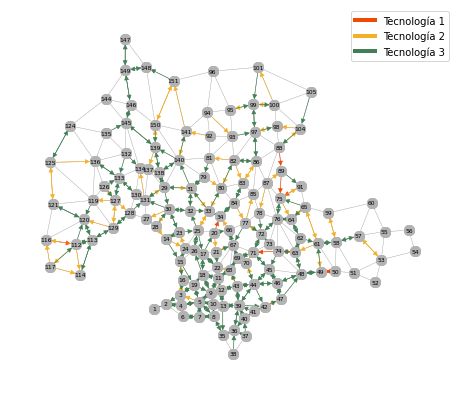

In [8]:
model, solution = instances[0]

bc.draw.draw(
    model,
    solution=solution,
    odpairs=False,
    infrastructures=True,
    width=0.3,
    **draw_config,
)

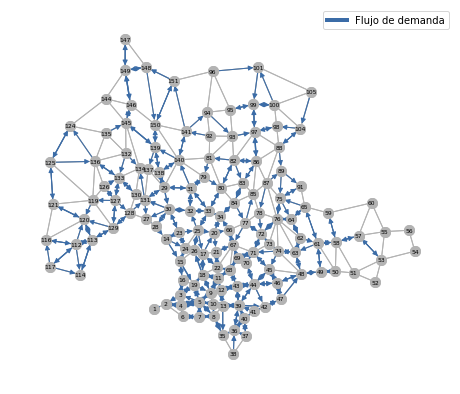

In [9]:
bc.draw.draw(
    model,
    solution=solution,
    odpairs=False,
    infrastructures=False,
    flows=True,
    **draw_config,
)

## Budget usage per instance

In [10]:
def get_budget_use_summary(data_path):
    df = pd.read_csv(os.path.join(data_path, 'abudget_use_summary.csv'))

    infra_length_columns = [c for c in df.columns if 'length' in c]
    df['total_length'] = df[infra_length_columns].fillna(0.0).apply(np.sum, axis=1)
    
    return df

In [11]:
bdf = get_budget_use_summary(data_path)

infra_length_columns = [c for c in bdf.columns if 'length' in c]

In [12]:
bdf[['name', 'total_length'] + infra_length_columns]

,name,total_length,infra_1_length_percentage,infra_2_length_percentage,infra_3_length_percentage,infra_total_length,total_length
0,montevideo_d3000.0_linear_0.1_budget_factor,7.783258,0.313581,2.335455,1.242593,3.891629,7.783258
1,montevideo_d3000.0_linear_0.4_budget_factor,27.771763,0.588372,6.929961,6.367548,13.885881,27.771763
2,montevideo_d3000.0_inv_logit_0.4_budget_factor,27.189298,0.354068,6.826881,6.413699,13.594649,27.189298
3,montevideo_d3000.0_linear_0.8_budget_factor,52.316628,0.338838,11.886277,13.933198,26.158314,52.316628
4,montevideo_d3000.0_inv_logit_0.8_budget_factor,54.082470,1.097719,12.470257,13.473259,27.041235,54.082470
5,montevideo_d3000.0_linear_1.6_budget_factor,91.153425,1.045292,9.610020,34.921401,45.576712,91.153425
6,montevideo_d3000.0_inv_logit_1.6_budget_factor,94.839096,1.392454,12.758019,33.269074,47.419548,94.839096


## Desviacion sobre el camino más corto en distancia

Comparación entre el camino más corto en costo de usuario y el camino más corto en distancia.

Los datos son mostrados en por percentiles ponderados en segun la cantida de viajes, es decirl la demanda transferida de cada par origen-destino.

In [13]:
def get_shortest_path_cmp(model, solution):
    data = []
    
    graph = model.apply_solution_to_graph(solution)
    ods_demand = {
        f'{d.origin}-{d.destination}': d.demand_transfered
        for d in solution.data.demand_transfered
    }
    
    for (origin, destination, *_) in model.odpairs:      
        distance = nx.shortest_path_length(graph, origin, destination, weight='user_cost')
        user_cost_sp = nx.shortest_path(graph, origin, destination, weight='effective_user_cost')
        
        user_cost_distance = sum([
            graph.edges[n1, n2]['user_cost']
            for n1, n2 in zip(user_cost_sp[0:-1], user_cost_sp[1:])
        ])
        od = f'{origin}-{destination}'
        data.append(dict(
            od=od,
            distance=distance,
            user_cost_distance=user_cost_distance,
            ratio=user_cost_distance / distance,
            demand_transfered=ods_demand[od]
        ))
    

    df = pd.DataFrame(data)
    df = df[df.demand_transfered > 0.01]

    return df.sort_values(by=['ratio'])


def build_agg_dataset(dfs, insts, percentiles=[0.75, 0.9], include_max=True, raw_data=False):
    data = []
    
    for df, instance in zip(dfs, insts):
        model, solution = instance
        
        df_len = len(df)
        data_row = dict(
            name=model.name,
            od_affected=df_len,
        )
            
        def add_datapoint(percentile, value):
            value *= 100
            if raw_data:
                data_row['points'] = data_row.get('points', []) + [(percentile, value)]
            else:
                key = f'max{percentile}'
                data_row[key] = value
        
        total_demand = df.demand_transfered.sum()
        
        curr = 0
        percent = percentiles[:]
        percent = sorted(percent, reverse=True)
        curr_percentile = percent.pop()
        
        for _, row in df.iterrows():
            curr += row.demand_transfered
            
            if curr >= total_demand * curr_percentile:
                add_datapoint(curr_percentile, row.ratio)

                if percent:
                    curr_percentile = percent.pop()
                else:
                    break
        if include_max:
            add_datapoint(1, df.iloc[-1].ratio)

        data.append(data_row)
    
    if raw_data:
        return data
    else:
        return pd.DataFrame(data)

In [14]:
dfs = [get_shortest_path_cmp(*instance) for instance in first_round_instances]

In [15]:
aggdf = build_agg_dataset(dfs, first_round_instances, percentiles=[0.75, 0.90, 0.95, 0.98])

aggdf = aggdf.set_index('name').reindex(index=bdf.name).reset_index().dropna()

# This is for the doc
aggdf.round(2).assign(instance=range(1, len(aggdf) + 1)) \
                      [['instance'] + list(aggdf.columns.difference(['name', 'od_affected'], sort=False))] \
                      .to_csv(os.path.join(data_path, 'apath_deviation.csv'), index=False)


aggdf

,name,od_affected,max0.75,max0.9,max0.95,max0.98,max1
1,montevideo_d3000.0_linear_0.4_budget_factor,395.0,100.0,100.000000,109.918666,117.223468,146.377279
2,montevideo_d3000.0_inv_logit_0.4_budget_factor,373.0,100.0,107.984224,111.098255,117.104646,143.356143
3,montevideo_d3000.0_linear_0.8_budget_factor,513.0,100.0,100.000000,108.237378,118.264466,143.356143
4,montevideo_d3000.0_inv_logit_0.8_budget_factor,510.0,100.0,103.844967,110.297129,117.223468,141.013604
5,montevideo_d3000.0_linear_1.6_budget_factor,598.0,100.0,100.000000,100.000000,109.707289,141.503196
6,montevideo_d3000.0_inv_logit_1.6_budget_factor,597.0,100.0,100.000000,100.998758,110.424097,133.151348


### Grafica del desvio en porcentajes 

In [37]:
min_percentile = 87
percentiles = np.arange(0.87, 10.1, step=0.005)

data = build_agg_dataset(dfs, first_round_instances, percentiles=percentiles, include_max=True, raw_data=True)
data = sorted(data, key=lambda d: instances_number[d['name']])

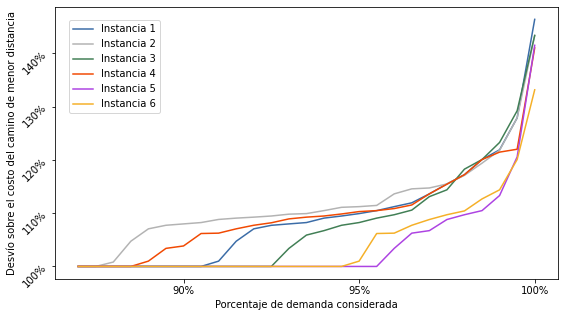

In [39]:
fig, ax = plt.subplots(figsize=(9, 5))

colors = [
    bc.colors.blue,
    bc.colors.gray_light,
    bc.colors.green,
    bc.colors.orange,
    bc.colors.violet,
    bc.colors.yellow,
]

for color, entry in zip(colors, data):
    x, y = zip(*entry['points'])
    instance_number = instances_number[entry['name']]
    ax.plot(x, y, color=color, label=f'Instancia {instance_number}')

ax.set_ylabel('Desvío sobre el costo del camino de menor distancia')
ax.set_xlabel('Porcentaje de demanda considerada')

y_ticks = [100 + 10 * n for n in range(5)]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{t}%' for t in y_ticks])
ax.tick_params(axis='y', which='both', labelrotation=45)

x_ticks = np.arange(0.9, 1.01, step=0.05)
ax.set_xticks(x_ticks)
ax.set_xticklabels(['{:.0f}%'.format(100 * t) for t in x_ticks])

ax.legend(loc=(0.027, 0.61))

fig.savefig(
    os.path.join(resources_path, 'montevideo_shortest_path_distance_deviation.png'),
    dpi=300,
)
    

## Apply solution to complete set of demands under 3 km

In [18]:
def find_model(substr):
    for value in instances:
        if substr in value[0].name:
            return value
    return None

model01, model01_sol = find_model('0.1')
model_logit, _ = find_model('inv_logit')

create_model = partial(
    bc.model.Model,
    nodes_file=os.path.join(raw_data_path, 'nodes.csv'),
    arcs_file=os.path.join(raw_data_path, 'arcs.csv'),
    budget=model01.budget,
)

modeld3k = create_model(
    name='montevideo_d3000.0_linear_0.01_all_od',
    odpairs_file=os.path.join(raw_data_path, 'demands_d3000.0.csv'),
    breakpoints=model01.breakpoints,
)

modeld3k_logit = create_model(
    name='montevideo_d3000.0_inv_logit_0.01_all_od',
    odpairs_file=os.path.join(raw_data_path, 'demands_d3000.0.csv'),
    breakpoints=model_logit.breakpoints,
)

modelfulld = create_model(
    name='montevideo_linear_0.01_all_od',
    odpairs_file=os.path.join(raw_data_path, 'demands.csv'),
    breakpoints=model01.breakpoints,
)

In [19]:
modeld3k_sol = modeld3k.apply_to_solution(model01_sol)
modeld3k_logit_sol = modeld3k_logit.apply_to_solution(model01_sol)
modelfulld_sol = modelfulld.apply_to_solution(model01_sol)

metrics_instances = [
    (model01, model01_sol),
    (modeld3k, modeld3k_sol),
    (modeld3k_logit, modeld3k_logit_sol),
    (modelfulld, modelfulld_sol),
]

In [20]:
def get_metrics(model, solution):
    """
    Return dict with data about model solution pair
    """
    _, _, demand = zip(*model.odpairs)
    total_demand = sum(demand)
    
    return dict(
        name=model.name,
        pares_od=len(model.odpairs),
        total_demand_transfered=solution.total_demand_transfered,
        total_demand=total_demand,
        total_demand_transfered_percentage=solution.total_demand_transfered / total_demand,
    )

In [21]:
df = pd.DataFrame(get_metrics(*values) for values in metrics_instances)
df

,name,pares_od,total_demand_transfered,total_demand,total_demand_transfered_percentage
0,montevideo_d3000.0_linear_0.1_budget_factor,600,439048.000000,1794911.0,0.244607
1,montevideo_d3000.0_linear_0.01_all_od,1703,489171.483248,2652707.0,0.184405
2,montevideo_d3000.0_inv_logit_0.01_all_od,1703,471246.251315,2652707.0,0.177647
3,montevideo_linear_0.01_all_od,6184,962946.064006,6568837.0,0.146593
